<a href="https://colab.research.google.com/github/nascimento-luciano/Artificial-Intelligence/blob/master/Segmenta%C3%A7%C3%A3o_de_imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**UNIVERSIDADE FEDERAL DO AGRESTE DE PERNAMBUCO**

**Redes Neurais [MÓDULO 04] - Prof. Dr. Luis F. Alves Pereira**

---
**Conteúdo:**

* Segmentação Semântica vs. Segmentação por Instâncias
* Arquitetura Encoder-Decoder
* The Fully Convolutional Network (FCN)
  * Usando FCNs para segmentar imagens coletadas por veículos autônomos
    * Baixando uma amostra da base CamVid
    * Funcionalidades para manipulação de dados
    * Funcionalidades para visualização de dados
    * Definição do modelo

---


#1. Segmentação Semântica vs. Segmentação por Instâncias

A imagem a seguir ilustra a diferenciação entre a segmentação semântica, a segmentação de instâncias e outros problemas em visão computacional. Veja que na segmentação semântica, todos os indivíduos pertencentes a uma mesma classe são identificados através de uma label única. Na segmentação de instâncias, cada indivíduo recebe uma label específica.

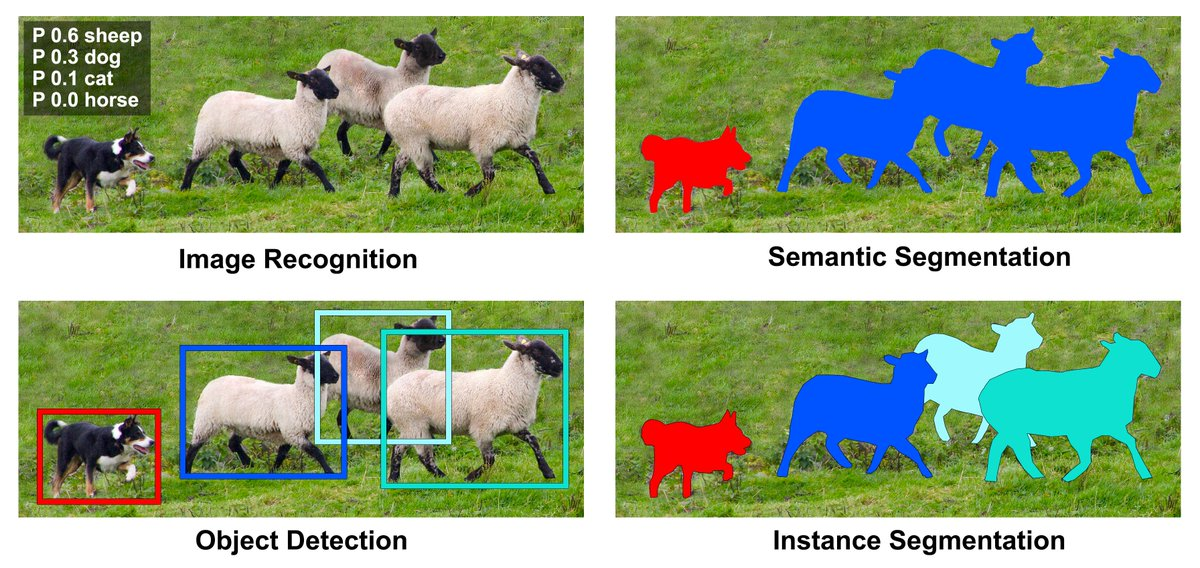

#2. Arquitetura Encoder-Decoder

A segmentação semântica é tipicamente alcançada através da arquitetura encoder decoder. Como vimos em sala de aula, a topologia dessa arquitetura segue a ilustração a seguir. A partir de um vetor de características (antes utilizado como entrada para camadas densamente conectadas em problemas de classificação), realiza-se sucessivos upsamples com o objetivo de se recuperar o mesmo tamanho da imagem de entrada.

O batch de entrada é tipicamente apresendado no formato $[batch\_size, img\_heigh, img\_width, number\_of\_color\_channels]$, e o batch de saída $[batch\_size, img\_heigh, img\_width, number\_of\_classes]$. Dessa forma, o batch de saída $output[0,:,:,0]$ deve conter valores próximos de $1$ para os pixels da primeira imagem do batch que pertencem a classe $0$, e valores próximos a $0$ para os pixels que não pertencem a classe $0$.

Portanto, a função de ativação na última camada da rede geralmente é a $sigmoid$ e a *loss* é tipicamente a *Binary Cross Entropy*.

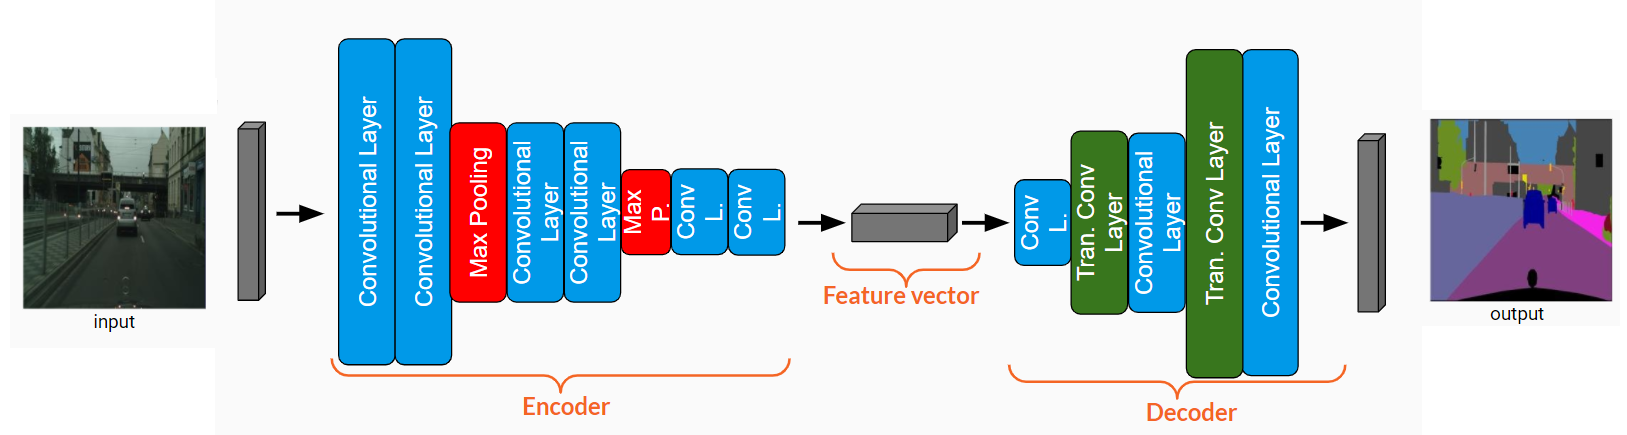

#3. The Fully Convolutional Network (FCN)

Um dos primeiros modelos profundos para segmentação semântica de imagens foi apresentado [neste artigo](https://arxiv.org/abs/1411.4038). A Fully Convolutional Network recebeu esse nome provavelmente pela substituição das camadas densamente conectadas (*dense connected*) nas Fully Connected Networks (para classificação de images) por camadas convolucionais (transpostas) para upsample da representação intermediária.

As imagens a seguir, retiradas da publicação original, ilustram a arquitetura encoder-decoder (Figura 1), e a possibilidade de usar uma variedade de redes pré-treinadas para classifição como componente encoder da FCN (Figura 2).


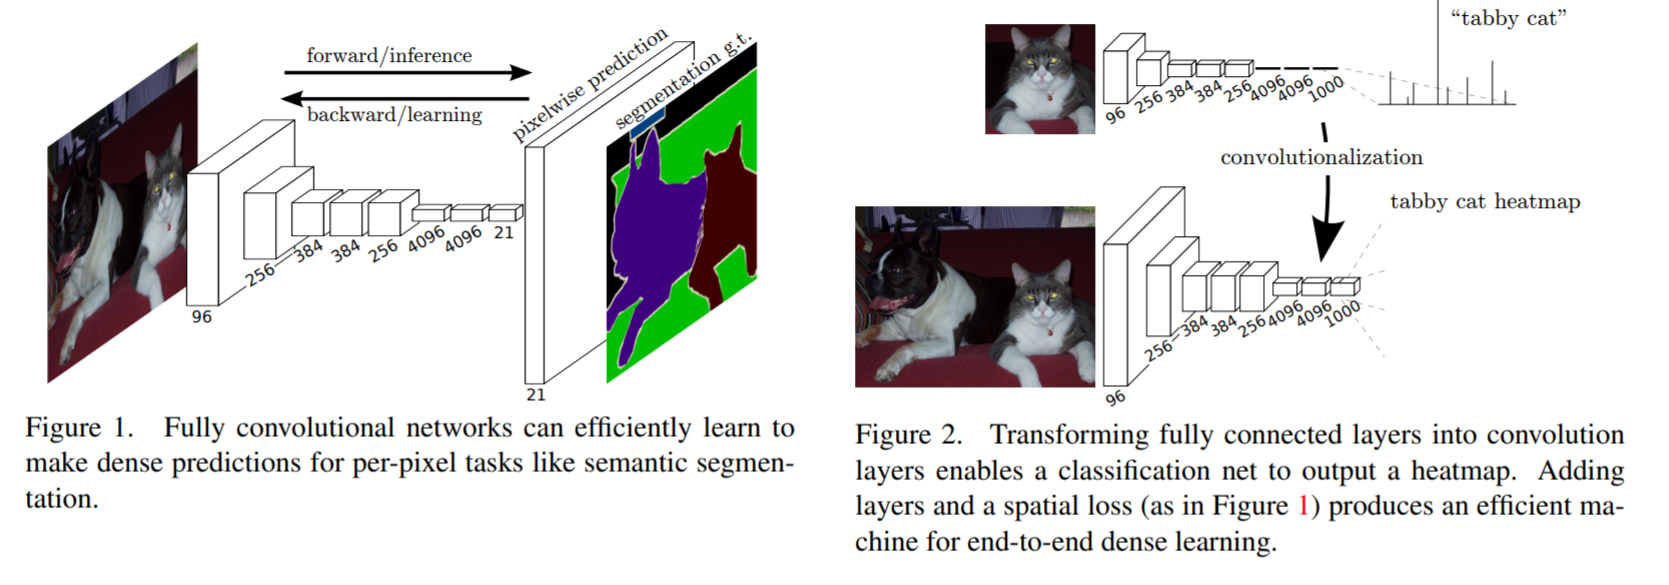

O método de upsampling da FCN pode se dar de três formas:



*   Upsample $32\times$ diretamente do tensor gerado pela camada *pool5* (resultado de um downsample $32\times$ em relação a imagem original). Essa abordagem gera a rede FCN-32.
*   *Skip connection* entre o tensor gerado pela camada *pool4* (resultado de um downsample $16\times$ em relação a imagem original) e o upsample $2\times$ do tensor gerado pela camada *pool5*. Essa abordagem gera a rede FCN-16.
*  *Skip connection* entre o upsample $2\times$ da saída da FCN-16 e o tensor gerado pela camada *pool3* (resultado de um downsample $8\times$ em relação a imagem original). Essa abordagem gera a rede FCN-8.




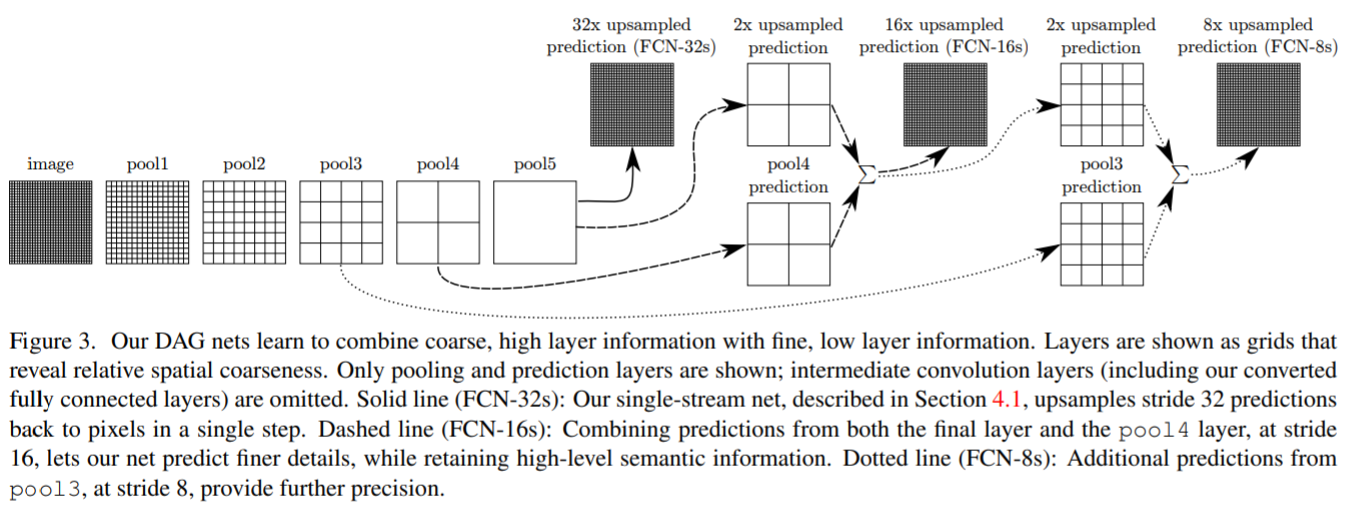

##3.1. Usando FCNs para segmentar imagens coletadas por veículos autônomos

###3.1.1. Baixando uma amostra da base [CamVid](http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/)


In [ ]:
%%writefile download.sh

#!/bin/bash
fileid="0B0d9ZiqAgFkiOHR1NTJhWVJMNEU"
filename="/tmp/fcnn-dataset.zip"
html=`curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}"`
curl -Lb ./cookie "https://drive.google.com/uc?export=download&`echo ${html}|grep -Po '(confirm=[a-zA-Z0-9\-_]+)'`&id=${fileid}" -o ${filename}

Writing download.sh


In [ ]:
!bash download.sh

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  119M  100  119M    0     0  89.6M      0  0:00:01  0:00:01 --:--:--  210M


In [ ]:
import zipfile
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

In [ ]:
!ls /tmp/fcnn/dataset1 #organização de pastas na raiz do dataset baixado

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


###3.1.2. Funcionalidades para manipulação dos dados

As funções que seguem foram geradas a partir de pequenas modificações das disponibilizadas para o curso *Advanced Computer Vision with TensorFlow* da plataforma *Coursera*:

In [ ]:
import tensorflow as tf
import os

BATCH_SIZE = 16
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

def map_filename_to_image_and_mask(t_filename, a_filename, height=224, width=224):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
   

  return validation_dataset  

# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

**[IMPORTANTE]** Veja com atenção as dimensões dos tensores X e Y que compõe a base de treinamento.

As imagens de entrada possuem três canais de cores por se tratarem de imagens RGB.

O ground truth (segmentação desejada) possue um canal para cada classe da segmentação.

In [ ]:
print('Training set composed of {} batches'.format(len(training_dataset)))

for i, (x, y) in enumerate(training_dataset):
  print('batch {}: X: {} Y: {}'.format(i, x.shape, y.shape))


Training set composed of 23 batches
batch 0: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 1: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 2: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 3: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 4: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 5: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 6: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 7: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 8: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 9: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 10: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 11: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 12: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 13: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 14: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 15: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 16: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 17: X: (16, 224, 224, 3) Y: (16, 224, 224, 12)
batch 18: X: (16, 22

Investigando um pouco mais o tensor de saída Y, vemos que ele é composto apenas por máscaras binárias (1 ou 0) para indicar os pixels da imagem de entrada que estão associados a cada um dos objetos/classes do problema.

No exemplo a seguir, você pode viajar por diversas imagens do último batch da base alterando o indice *seg_idx* e a classe de interesse *seg_class*:



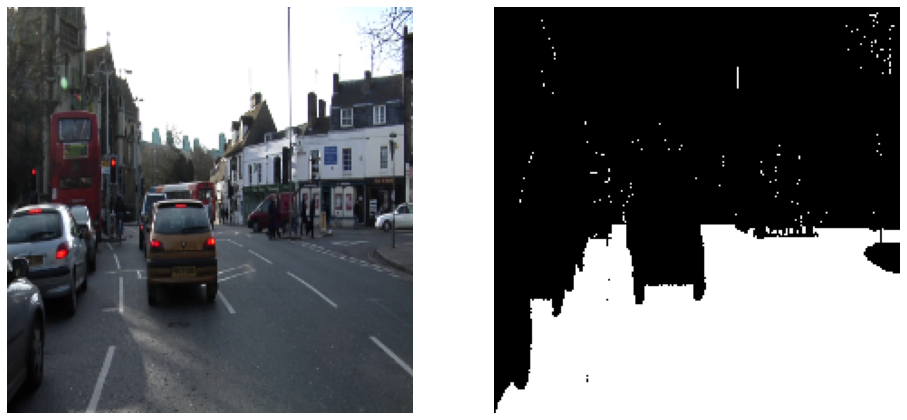

unique values in the input tensor:  105525
unique values in the output tensor: 2


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

img_idx = 8
seg_class = 'road' #road, sky, side walk 

fig = plt.gcf()
fig.set_size_inches(16, 8)

sp = plt.subplot(1, 2, 1)
sp.axis('Off')
plt.imshow((x[img_idx,:,:,:]+1)/2)

sp = plt.subplot(1, 2, 2)
sp.axis('Off')
plt.imshow(y[img_idx,:,:,class_names.index(seg_class)], cmap='gray')
plt.show()

print('unique values in the input tensor: ', len(np.unique(x[img_idx,:,:,:])))
print('unique values in the output tensor:', len(np.unique(y[img_idx,:,:, class_names.index(seg_class)])))

###3.1.3. Funcionalidades para visualização de dados

As funções que seguem foram originalmente disponibilizadas para o curso *Advanced Computer Vision with TensorFlow* da plataforma *Coursera*:

In [ ]:
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import seaborn as sns

# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- RGB: {color}')

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

 

sky -- RGB: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- RGB: (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- RGB: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- RGB: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- RGB: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- RGB: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- RGB: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- RGB: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- RGB: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- RGB: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- RGB: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- RGB: (1.0, 0.4980392156862745, 0.054901960784313725)


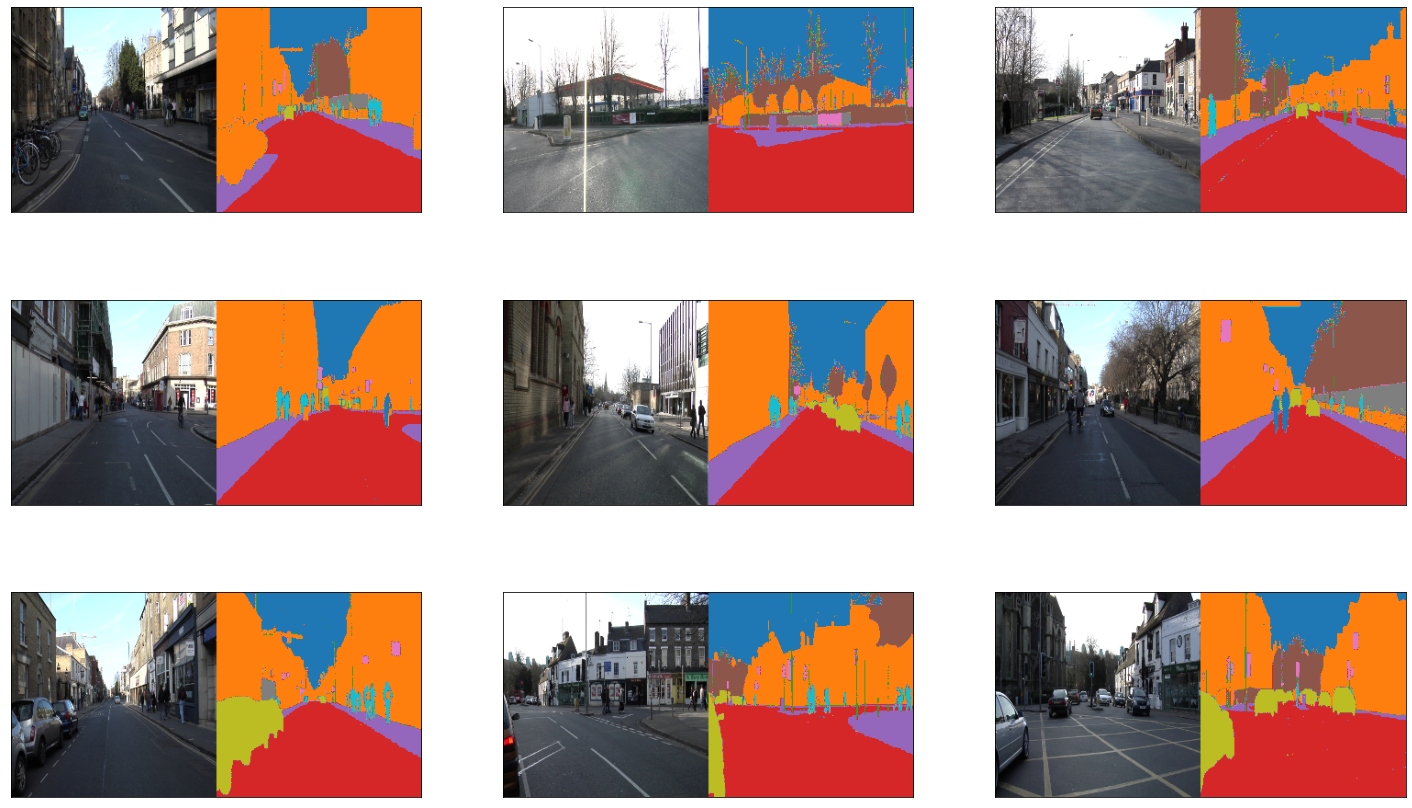

In [ ]:
list_show_annotation(training_dataset)

###3.1.4. Definição do modelo



In [ ]:

vgg19 = tf.keras.applications.VGG19(include_top=False,
                                                weights='imagenet',
                                                input_shape=(224,224,3))

vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
feature_extractor = tf.keras.models.Model(inputs=vgg19.input,
                                          outputs=[vgg19.get_layer('block1_pool').output,
                                                   vgg19.get_layer('block2_pool').output,
                                                   vgg19.get_layer('block3_pool').output,
                                                   vgg19.get_layer('block4_pool').output,
                                                   vgg19.get_layer('block5_pool').output])


In [ ]:
class FCN32(tf.keras.models.Model):
    
    def __init__(self, n_classes):
        super(FCN32, self).__init__()
        self.n_classes = n_classes
        self.feature_extractor = feature_extractor 
        self.convT = tf.keras.layers.Conv2DTranspose(filters=self.n_classes, kernel_size=(32, 32), use_bias=False, strides=(32,32), padding='same')
        self.final = tf.keras.layers.Conv2D(filters=self.n_classes, kernel_size=(8,8), activation='softmax', padding='same')

    def compute_output_shape(self, input_shape):
        self.inputShape = input_shape
        return (input_shape[0],input_shape[1],input_shape[2], self.n_classes)

    def call(self, inputs):

        pool1, pool2, pool3, pool4, pool5 = self.feature_extractor(inputs)     
        x = self.convT(pool5)
        x = self.final(x)
     
        return x

model = FCN32(n_classes=12)
model(tf.zeros((1,224,224,3)))
model.summary()

Model: "fcn32_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_6 (Functional)        [(None, 112, 112, 64),    20024384  
                              (None, 56, 56, 128),               
                              (None, 28, 28, 256),               
                              (None, 14, 14, 512),               
                              (None, 7, 7, 512)]                 
                                                                 
 conv2d_transpose_20 (Conv2D  multiple                 6291456   
 Transpose)                                                      
                                                                 
 conv2d_20 (Conv2D)          multiple                  9228      
                                                                 
Total params: 26,325,068
Trainable params: 26,325,068
Non-trainable params: 0
______________________________________________

In [ ]:
lr = 1e-3
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
train_acc = tf.keras.metrics.CategoricalAccuracy()
val_acc = tf.keras.metrics.CategoricalAccuracy()
n_epochs = 10

def train_step(x, y):  
    with tf.GradientTape() as tape:
        pred = model(x,training=True)
        err = loss(y,pred)

    grads = tape.gradient(err, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc.update_state(y, pred)
    return err

def val_step(x, y):
      pred = model(x,training=False)
      err = loss(y,pred)
      val_acc.update_state(y,pred)
      return err

In [ ]:
for epoch in range(n_epochs):

    total_train_loss = 0.0
    total_val_loss = 0.0

    for i, (x, y) in enumerate(training_dataset):
        total_train_loss += train_step(x, y)
        if i%10 == 0:
          print("batch {} executed...".format(i))
      
    print("EPOCH {} train_loss: {} train_acc: {}".format(epoch,total_train_loss/len(training_dataset),train_acc.result()))

    for x, y in validation_dataset:
        total_val_loss += val_step(x, y)

    print("EPOCH {} val_loss: {} val_acc: {}".format(epoch,total_val_loss/len(validation_dataset),val_acc.result()))


    train_acc.reset_states()
    val_acc.reset_states()

batch 0 executed...
batch 10 executed...
batch 20 executed...
EPOCH 0 train_loss: 4.794750213623047 train_acc: 0.31702619791030884
EPOCH 0 val_loss: 1.7891426086425781 val_acc: 0.4580344557762146
batch 0 executed...
batch 10 executed...
batch 20 executed...
EPOCH 1 train_loss: 1.513026237487793 train_acc: 0.5173665285110474
EPOCH 1 val_loss: 1.4180419445037842 val_acc: 0.5277348756790161
batch 0 executed...
batch 10 executed...
batch 20 executed...
EPOCH 2 train_loss: 1.159794569015503 train_acc: 0.6267754435539246
EPOCH 2 val_loss: 1.2221871614456177 val_acc: 0.58461993932724
batch 0 executed...
batch 10 executed...
batch 20 executed...
EPOCH 3 train_loss: 1.0241049528121948 train_acc: 0.6700687408447266
EPOCH 3 val_loss: 1.1641063690185547 val_acc: 0.5872424244880676
batch 0 executed...
batch 10 executed...
batch 20 executed...
EPOCH 4 train_loss: 0.989998996257782 train_acc: 0.6792382597923279
EPOCH 4 val_loss: 1.0937461853027344 val_acc: 0.5906488299369812
batch 0 executed...
batch

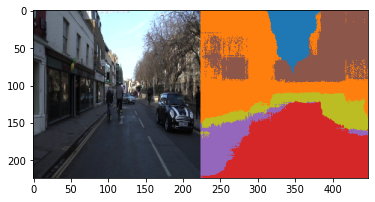

In [ ]:
x, y = iter(validation_dataset).get_next()
results = model.predict(x)


show_annotation_and_image(x[15],results[15])